In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns
import scipy.stats as stats
import sklearn
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

import lightgbm
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import seaborn as sns
dirname = '../production/dataset/'



Проанализируем самый крупный датасет из рекомендованных к решению задачи 

https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

Посмотрим на то, как выглядит датасет

In [2]:
df = pd.read_csv(dirname + "cardio_train.csv", sep=";")
df.drop("id",axis=1,inplace=True)
df.drop_duplicates(inplace=True)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Посмотрим, есть ли в датасете пропуски

In [3]:
df.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Добавим в датасет несколько важных характеристик, ИМТ и пульсовое давление. Кроме того переведем возраст из числа дней в более удобно интерпретируемую характеристику, а именно число лет.

In [4]:
df["bmi"] = df["weight"]/ (df["height"]/100)**2
df['diff'] = df['ap_hi'] - df['ap_lo']
df['age'] = (df['age'] / 365).round().astype('int')
df["gender"] = df["gender"] % 2

Посмотрим на статистику вещественных характеристик

In [5]:
cont_columns = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'diff', 'bmi']
df[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'diff', 'bmi']].describe()

,age,height,weight,ap_hi,ap_lo,diff,bmi
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,53.338945,164.359152,74.208519,128.820453,96.636261,32.184192,27.557610
std,6.765633,8.211218,14.397211,154.037729,188.504581,241.511001,6.092210
min,30.000000,55.000000,10.000000,-150.000000,-70.000000,-10800.000000,3.471784
25%,48.000000,159.000000,65.000000,120.000000,80.000000,40.000000,23.875115
50%,54.000000,165.000000,72.000000,120.000000,80.000000,40.000000,26.391837
75%,58.000000,170.000000,82.000000,140.000000,90.000000,50.000000,30.222222
max,65.000000,250.000000,200.000000,16020.000000,11000.000000,15940.000000,298.666667


Заметим, что в данных есть явные аномальные значения. Выбросим из датасета людей с аномально большим или маленьким ростом, с аномально большим или низким давлением, имт, с пульсовым давлением меньшим нуля, с аномально маленьким весом

In [6]:
out_filter = ((df["ap_hi"] > 250) | (df["ap_lo"] > 200) | (df["ap_hi"] <= 40) | 
              (df["ap_lo"] <= 40) | (df["diff"] <= 0) | (df['height'] < 120) | 
              (df['height'] >= 220) | (df["weight"] <= 30) | (df['bmi'] >= 50) |
              (df['bmi'] <= 15))
df = df[~out_filter]

Рассмотрим распределения данных

Посмотрим, есть ли явные зависимости в числовых параметрах

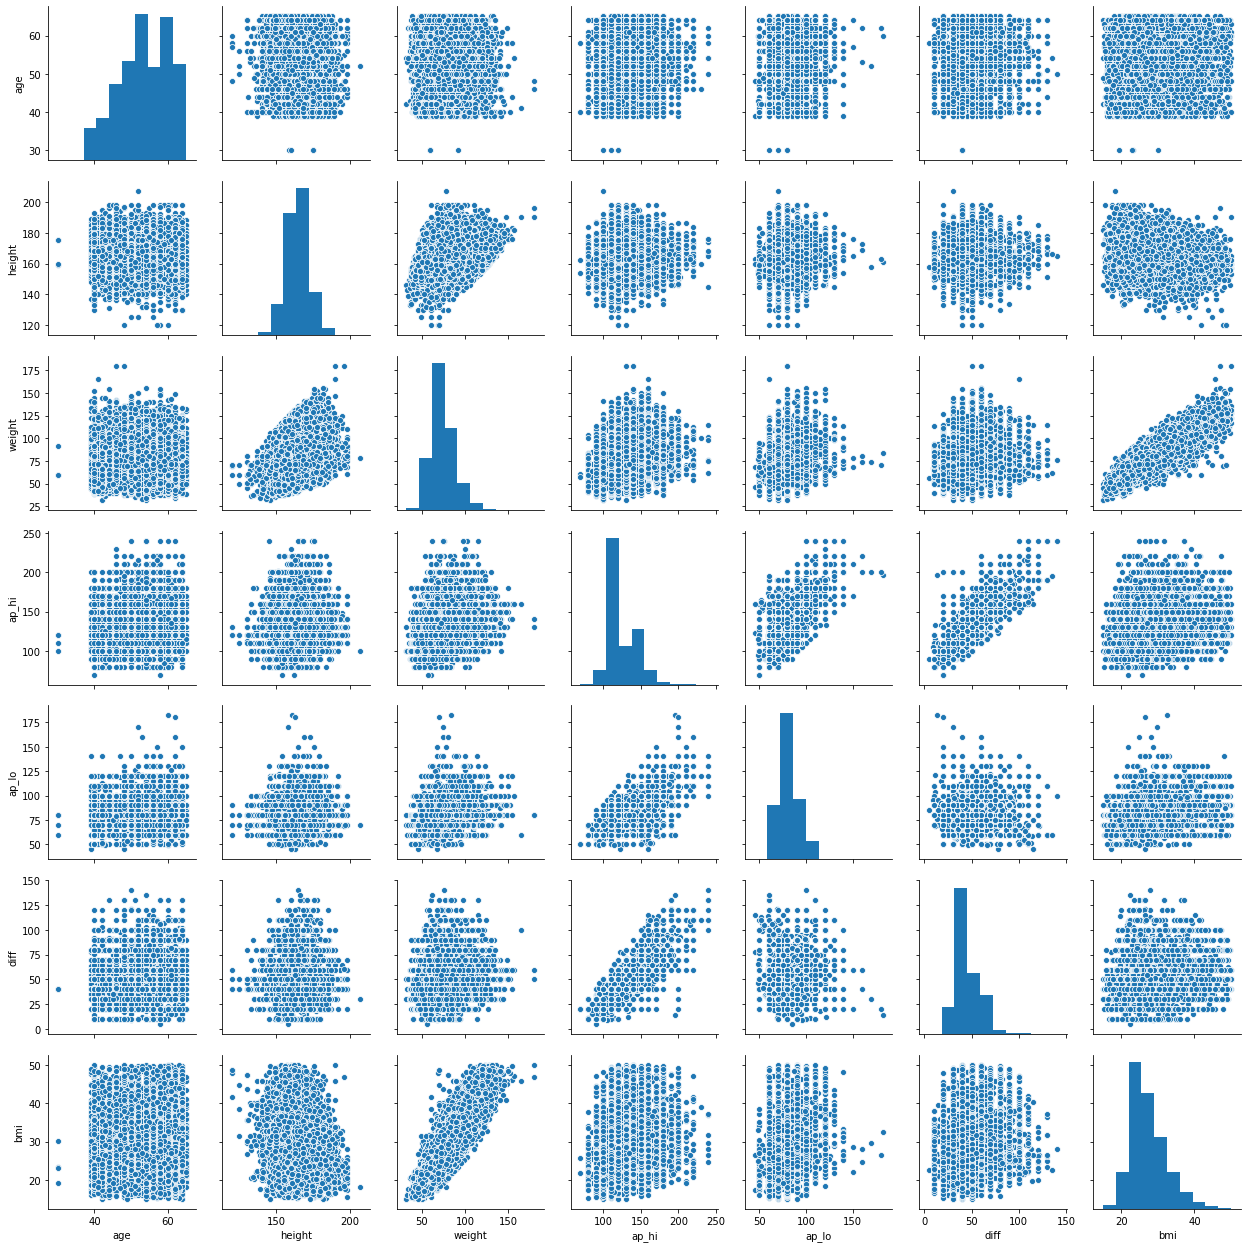

In [7]:
sns.pairplot(df[cont_columns])

Посмотрим на тепловую карту корреляци

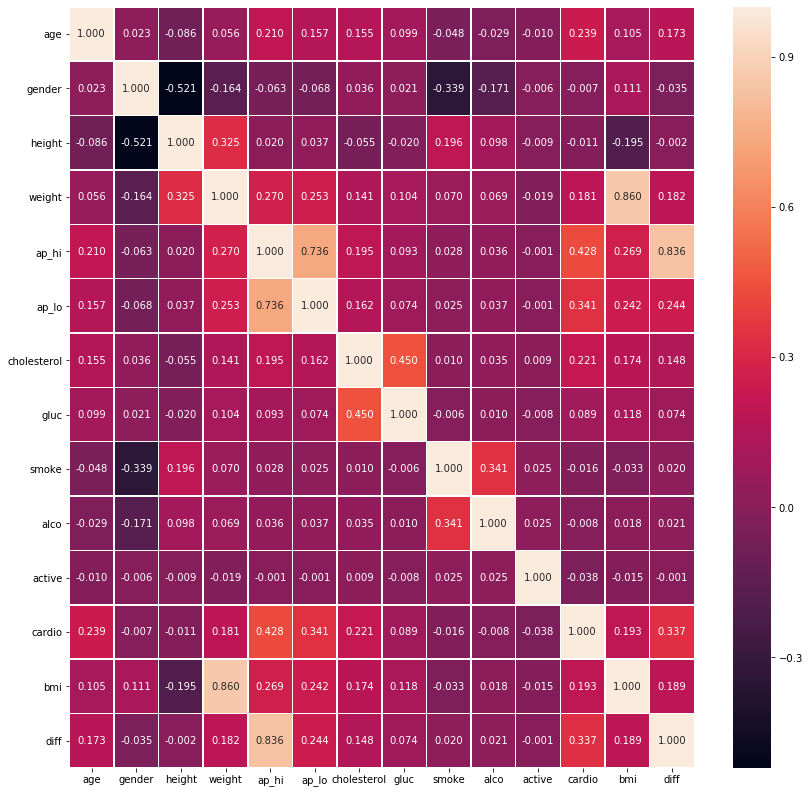

In [8]:
corr = df.corr()
f, ax = plt.subplots(figsize = (14,14))
sns.heatmap(corr, annot=True, fmt=".3f", linewidths=0.5, ax=ax)

Переведем категориальные перменные в бинарные, при помощи процедуры one-hot encoding

In [9]:
ord_cols = ['cholesterol', 'gluc']

for col in ord_cols:
    dummies = pd.get_dummies(df[col])
    dummies.columns = ['{0}_{1}'.format(col, ind) for ind in dummies.columns]
    df = pd.concat([df, dummies], axis=1)
df = df.drop(labels=['cholesterol', 'gluc'], axis=1)

Разобьем выборку на тестовую и тренировочную

In [10]:
y = df["cardio"]
x = df.drop("cardio", axis=1)
x_train,x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

Посмотрим на результаты предсказаний различных моделей

In [11]:
dec = DecisionTreeClassifier()
ran = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=100)
svm = SVC(random_state=1)
naive = GaussianNB()
cat_boost = CatBoostClassifier(silent=True)
xgb = XGBClassifier()
lgb = LGBMClassifier()
models = {"Decision tree" : dec,
          "Random forest" : ran,
          "KNN" : knn,
          "SVM" : svm,
          "Naive bayes" : naive,
          "cat_boost" : cat_boost,
          "xgb" : xgb,
          "lgbm" : lgb
          }
scores = { }
f1_res = {}
pre_res = {}
rec_res = {}



for key, value in models.items():    
    model = value
    model.fit(x_train, y_train)
    scores[key] = model.score(x_test, y_test)
    y_pred = model.predict(x_test)
    f1_res[key] = f1_score(y_test, y_pred)
    rec_res[key] = recall_score(y_test, y_pred)
    pre_res[key] = precision_score(y_test, y_pred)
    print('done', key)
  


done Decision tree
done Random forest
done KNN


d:\python3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


done SVM
done Naive bayes
done cat_boost
done xgb
done lgbm


Рассмотрим различные метрики качества моделей

In [12]:
cols = ["Accuracy Score", "f1", "precision", "recall"]
scores_frame = pd.DataFrame([scores,f1_res, pre_res, rec_res],  index=cols).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
scores_frame

,Accuracy Score,f1,precision,recall
lgbm,0.742211,0.729782,0.766259,0.696619
cat_boost,0.739432,0.727495,0.761935,0.696034
xgb,0.738262,0.725221,0.762758,0.691204
KNN,0.725684,0.707205,0.757779,0.662959
SVM,0.713617,0.704497,0.727216,0.683155
Random forest,0.711277,0.705461,0.719525,0.691936
Naive bayes,0.693506,0.656278,0.746455,0.585541
Decision tree,0.645020,0.635531,0.652583,0.619347


Видно, что наилучший результат показывает градиентный бустинг LGBM

Подберем для градиентного бустинга LGBM наилучшие параметры по метрике f1 score

In [13]:
gridParams = {
    'learning_rate': [0.1],
    'n_estimators': [100],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [42], # Updated from 'seed'
    'colsample_bytree' : [1],
    'subsample' : [1],
    'num_leaves': list(np.logspace(0.5, 1.7, 10).astype(int)) + [31],
    'random_state' : [42],
    'reg_alpha' : np.logspace(-1, 0.5, 15),
    'reg_lambda' : np.logspace(-1, 0.5, 15),
    }


mdl = LGBMClassifier()


grid = GridSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=-2, scoring='f1')

grid.fit(x_train, y_train)


print(grid.best_params_)
print(grid.best_score_)

{'boosting_type': 'gbdt', 'colsample_bytree': 1, 'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 5, 'objective': 'binary', 'random_state': 42, 'reg_alpha': 3.1622776601683795, 'reg_lambda': 3.1622776601683795, 'subsample': 1}
0.7182111451153022


Подберем наилучший баланс между точностью и полнотой.

Полнота характеризует вероятность того, что мы обнаружим проблему у заболевшего.
Точность характеризует вероятность того, что мы не ошиблись, предсказав пользователю то, что он болен

С учетом специфики задачи, нам важна высокая полнота для большего охвата больных

In [14]:
model = LGBMClassifier(**grid.best_params_)
model.fit(x_train, y_train)
arr = np.linspace(0.05, 0.95, 19)
for p in arr:
    y_pred = (model.predict_proba(x_test)[:, 1] > p)
    acc = (y_pred == y_test).mean()
    f1 = f1_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)

    print("p {}, acc {}, f1 {}, pre {}, rec {}".format(p, acc, f1, pre,rec))

p 0.05, acc 0.49985373701916047, f1 0.6664715922945623, pre 0.4997805734347572, rec 1.0
p 0.1, acc 0.5160157964019306, f1 0.6734432053685976, pre 0.5080026799672448, rec 0.9986828625786623
p 0.15, acc 0.5577007459412023, f1 0.6904176904176904, pre 0.5308982130205463, rec 0.9869749743889946
p 0.2, acc 0.6004826678367705, f1 0.7070934534341323, pre 0.5579624301912337, rec 0.9650226840333674
p 0.25, acc 0.6419482229047828, f1 0.7228260869565217, pre 0.5894192595328225, rec 0.9342894775354895
p 0.3, acc 0.6953342109112184, f1 0.7428712504629057, pre 0.6423310918988152, rec 0.8807258890677594
p 0.35, acc 0.7229047827994735, f1 0.7498514557338087, pre 0.6830647101274958, rec 0.8311137128640421
p 0.39999999999999997, acc 0.7392131051630833, f1 0.7492264416315049, pre 0.721131717882767, rec 0.7795990048295038
p 0.44999999999999996, acc 0.7414070498756765, f1 0.741784723236454, pre 0.740271097507652, rec 0.7433045514415337
p 0.49999999999999994, acc 0.7442591780020477, f1 0.7346938775510204, pr

d:\python3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\python3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Мы можем выбирать разные пороги, в зависимости от желаемой пары точность\полнота. Для своей модели мы выбрали порог 0.3

Выведем важность параметров в бустинге

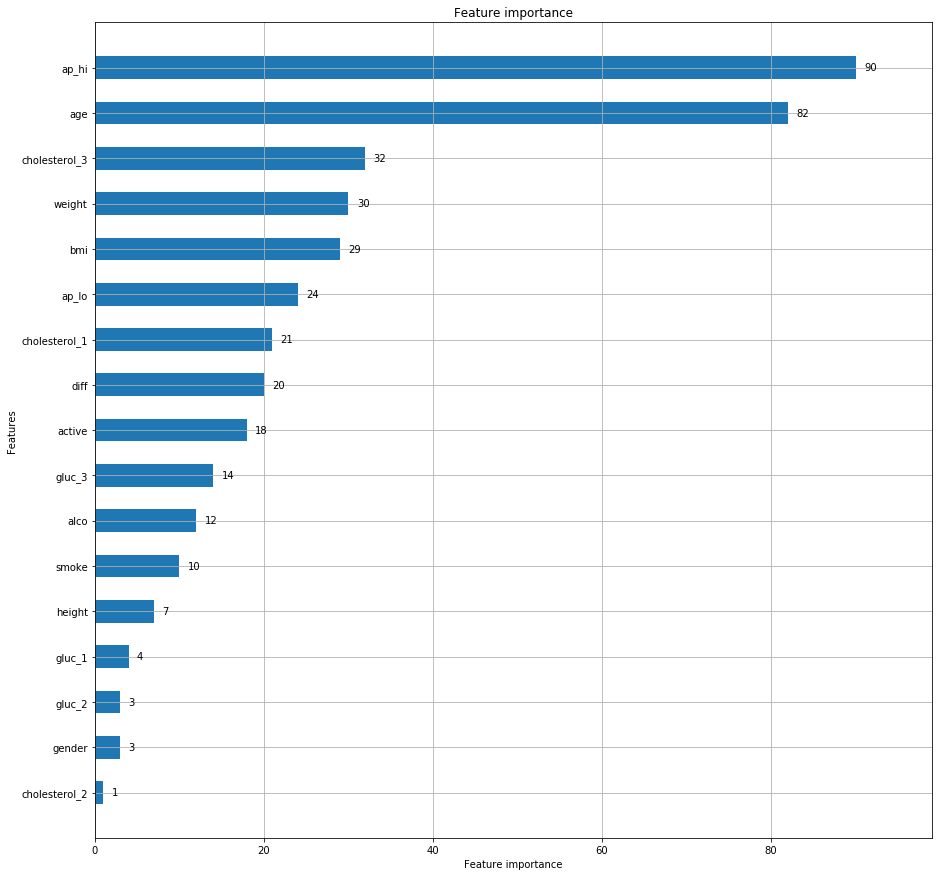

In [15]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
lightgbm.plot_importance(model,ax = axes,height = 0.5)
plt.show();
plt.close()